In [2]:
import polars as pl
import polars_ds as pds
import seaborn as sns
from utils import prep
import matplotlib.pyplot as plt

c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Les inn data 

In [3]:
df = pl.read_excel("treningsdata.xlsx")

In [4]:
df = prep(df)

In [5]:
df.head()

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-01-06,"""Bakary Jang Konateh""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-01-06,"""Sindre Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-02-04,"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""Februar""",4,2
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Antall treninger per måned')

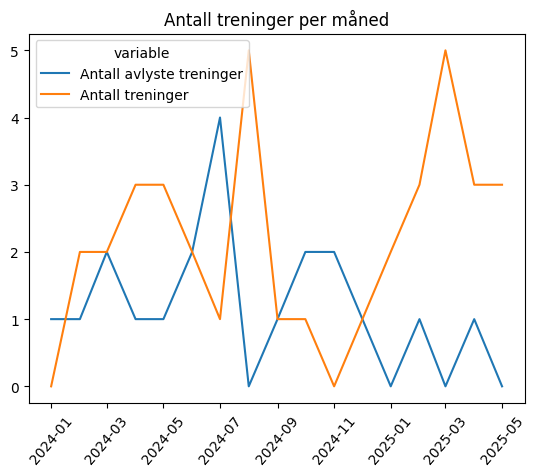

In [41]:
antall_treninger = (df
.group_by('År','Måned','Måned nr')
.agg(pl.col('Dato').filter(pl.col('Avlyst trening')=='Nei').n_unique().alias('Antall treninger'),
     pl.col('Dato').filter(pl.col('Avlyst trening')=='Ja').n_unique().alias('Antall avlyste treninger'))
)

antall_treninger = (antall_treninger
.unpivot(index = ['År','Måned','Måned nr'],on = ['Antall treninger','Antall avlyste treninger'])
.sort(by=['variable','År','Måned nr'])
)


antall_treninger = (
    antall_treninger
    .with_columns(
        pl.when(pl.col('Måned nr').cast(pl.String).str.len_chars() > 1)
        .then(
            pl.concat_str(
                [pl.col('År'), pl.col('Måned nr'), pl.lit('01')],
                separator="-"
            )
        )
        .otherwise(
            pl.concat_str(
                [
                    pl.col('År'),
                    pl.concat_str([pl.lit('0'), pl.col('Måned nr')]),
                    pl.lit('01')
                ],
                separator="-"
            )
        )
        .cast(pl.Date)
        .alias('d')  # valgfritt: gir navnet 'd' til kolonnen
    )
)


fig, ax = plt.subplots()
sns.lineplot(data = antall_treninger.to_pandas(), x='d', y='value',hue='variable',ax = ax)

from matplotlib.ticker import MaxNLocator
# Roter x-labels
ax.tick_params(axis='x', rotation=50)
ax.set_ylabel("")
ax.set_xlabel("")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Antall treninger per måned')


In [39]:
antall_treninger

År,Måned,Måned nr,variable,value,d
str,str,i64,str,u32,date
"""2024""","""April""",4,"""Antall avlyste treninger""",1,2024-04-01
"""2025""","""April""",4,"""Antall avlyste treninger""",1,2025-04-01
"""2024""","""April""",4,"""Antall treninger""",3,2024-04-01
"""2025""","""April""",4,"""Antall treninger""",3,2025-04-01


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Antall treninger per måned')

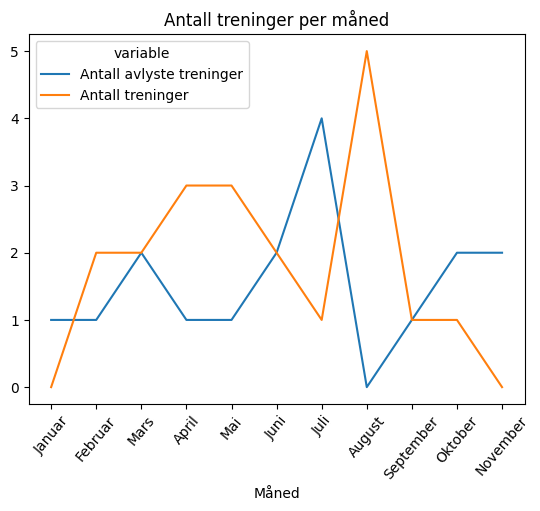

In [6]:
antall_treninger = (df
.group_by('Måned','Måned nr')
.agg(pl.col('Dato').filter(pl.col('Avlyst trening')=='Nei').n_unique().alias('Antall treninger'),
     pl.col('Dato').filter(pl.col('Avlyst trening')=='Ja').n_unique().alias('Antall avlyste treninger'))
)

antall_treninger = (antall_treninger
.unpivot(index = ['Måned','Måned nr'],on = ['Antall treninger','Antall avlyste treninger'])
.sort(by=['variable','Måned nr'])
.drop('Måned nr')
)


fig, ax = plt.subplots()
sns.lineplot(data = antall_treninger.to_pandas(), x='Måned', y='value',hue='variable',ax = ax)

# Roter x-labels
ax.tick_params(axis='x', rotation=50)
ax.set_ylabel("")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Antall treninger per måned')


In [9]:
(df
.group_by('Navn','Måned')
.agg(pds.query_longest_streak(pl.col('Deltok')=='Ja').alias('Streak'))
#.filter(pl.col('Navn').str.contains('Erlend'))
.sort(by = 'Streak')
)

Navn,Måned,Streak
str,str,u32
"""Carlos Tveit""","""September""",0
"""Patrick Waage Seljenes""","""Oktober""",0
"""Thomas Thorbjørnsen""","""Mai""",0
"""Patrick Waage Seljenes""","""Juni""",0
"""Ruben André M. Njøtøy""","""Mai""",0
…,…,…
"""Sindre Jakobsen""","""April""",4
"""Sindre Jakobsen""","""August""",5
"""Thomas Thorbjørnsen""","""August""",5


In [44]:
pl.Config(tbl_rows=50)
df.filter(pl.col('Navn')=='Erlend Haukefer Hauan')

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2
2024-02-17,"""Erlend Haukefer Hauan""","""Nei""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Mars""",8,3
2024-04-20,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",20,4
2024-04-28,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",28,4
2024-05-05,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mai""",5,5


<Axes: xlabel='Antall treninger', ylabel='Count'>

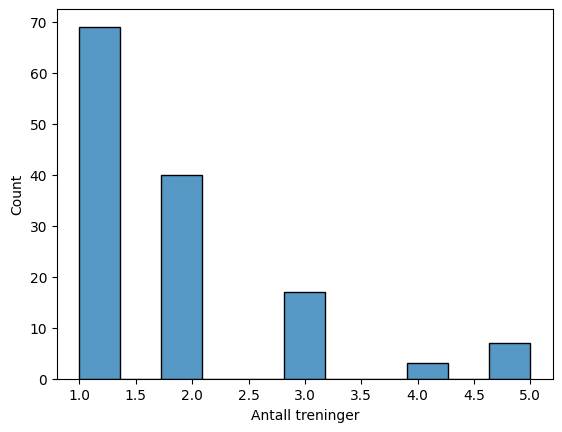

In [36]:
antall_treninger_deltaker = df.filter(pl.col('Avlyst trening')=='Nei').group_by('Navn','Måned').agg(pl.col('Dato').n_unique().alias('Antall treninger'))

fig, ax = plt.subplots()
sns.histplot(data = antall_treninger_deltaker.to_pandas(),x='Antall treninger',ax = ax)

# Roter x-labels
#ax.tick_params(axis='x', rotation=50)
#ax.set_ylabel("")
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_title('Antall treninger per måned')

In [30]:
antall_treninger.filter(pl.col('Måned')=='April')

Måned,variable,value
str,str,u32
"""April""","""Antall avlyste treninger""",3
"""April""","""Antall treninger""",3


In [6]:
(df
.group_by('Navn')
.agg(
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Antall treninger'),
     pl.col('Dato')
     .filter(pl.col('Deltok')=='Ja')
     .n_unique()
     .truediv(pl.col('Dato').n_unique())
     .alias('Andel treninger'))
#.sort(by = ['Antall treninger'])
)

Navn,Antall treninger,Andel treninger
str,u32,f64
"""Håkon Halvorsen""",1,0.5
"""Magnus Alexander Gjerde Bevan""",2,0.5
"""Ahmed Abusaada""",4,0.8
"""Markus Bjånesøy""",4,0.210526
"""Helge Håvås""",5,0.833333
…,…,…
"""Adrian S.Larsen""",2,0.5
"""Magnus Jensen""",0,0.0
"""Sondre Foldenes Gangdal""",0,0.0


In [18]:
df.sort(by = ['Navn', 'Dato'])

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3
2024-07-28,"""Adrian Torvund""","""Ja""","""Nei""","""2024""","""Juli""",28,7
…,…,…,…,…,…,…,…
2024-10-02,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",2,10
2024-10-08,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",8,10
2024-10-30,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Oktober""",30,10


Databearbehandling

In [ ]:
df.filter(pl.col('Navn')=="Adrian S.Larsen")

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.group_by('Navn')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
)

Navn,Antall treninger
str,u32
"""Kristoffer Fauskanger""",10
"""Carlos Tveit""",9
"""Jørgen Vassenden""",9
"""Sindre Jakobsen""",9
"""Sindre Haukefer Hauan""",9
…,…
"""Thomas Thorbjørnsen""",2
"""Adrian S.Larsen""",2
"""Håkon Halvorsen""",1


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.select('Dato','Navn')
.unique()
.group_by('Dato')
.agg(pl.col('Navn').alias('navn_1'),
     pl.col('Navn').alias('navn_2'),
     pl.col('Navn').alias('navn_3')
)

# Finner 3 kombinasjoner
.explode('navn_1')
.explode('navn_2')
.explode('navn_3')

# Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
.with_columns(pl.concat_str(['navn_1', 'navn_2', 'navn_3'], separator=',').str.split(",").alias('kombi'))

# Sorterer liste
.with_columns(pl.col('kombi').list.sort())

# Filtrerer på lister som har 3 unike navn (etter at duplikater er fjernet)
.filter(pl.col('kombi').lbist.unique().list.n_unique()==3)
.group_by('kombi')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
.with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
)

kombi,Antall treninger,Kombinasjon
list[str],u32,str
"[""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",8,"""Kristoffer Fauskanger,Sindre H…"
"[""Jørgen Vassenden"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Sindre Haukef…"
"[""Carlos Tveit"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Carlos Tveit,Kristoffer Fauska…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
…,…,…
"[""Magnus Alexander Gjerde Bevan"", ""Sindre Jakobsen"", ""Stian Nyheim""]",1,"""Magnus Alexander Gjerde Bevan,…"
"[""Carlos Tveit"", ""Jørgen Vassenden"", ""Thomas Thorbjørnsen""]",1,"""Carlos Tveit,Jørgen Vassenden,…"
"[""Jørgen Vassenden"", ""Stian Nyheim"", ""Thomas Syversen""]",1,"""Jørgen Vassenden,Stian Nyheim,…"


In [ ]:


# Funksjon for å få statistikk på kombinasjoner. Dersom antall_kombinasjon er lik 3 betyr det at vi er interessert i tripplett
def kombi_statistikk(antall_kombinasjon):

 # Lager antall navn expr
 navn_init =[f'navn_{i+1}' for i in range(antall_kombinasjon)]
 navn_expr = [pl.col('Navn').alias(f'navn_{i+1}') for i in range(antall_kombinasjon)]
 
 # Initialiserer datasett
 df_init = (df
 .filter(pl.col('Avlyst trening')=='Nei',
         pl.col('Deltok')=='Ja')
 .select('Dato','Navn')
 .unique()
 .group_by('Dato')
 .agg(*navn_expr)
 )
 
 # Exploder df for å finne alle kombinasjoner 
 for i in range(antall_kombinasjon):
    df_init = df_init.explode(navn_init[i])
 
 # Fjerner duplikater 
 df_kombi = (
 
 df_init
 
 # Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
 .with_columns(pl.concat_str(*navn_init, separator=',').str.split(",").alias('kombi'))
 
 # Sorterer liste
 .with_columns(pl.col('kombi').list.sort())
 
 # Filtrerer på lister som har x antall unike navn (etter at duplikater er fjernet)
 .filter(pl.col('kombi').list.unique().list.n_unique()==antall_kombinasjon)
 .group_by('kombi')
 .agg(pl.col('Dato').n_unique().alias('Antall treninger'))
 .sort(by = ['Antall treninger'],descending=True)
 .with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
 .select('Kombinasjon','Antall treninger')
 
 )

 return df_kombi



In [ ]:
df_kombi = kombi_statistikk(3)

In [ ]:
df_kombi.filter(pl.col('Kombinasjon').str.contains('Erlend Haukefer Hauan'))

Kombinasjon,Antall treninger
str,u32
"""Erlend Haukefer Hauan,Kristoff…",6
"""Carlos Tveit,Erlend Haukefer H…",5
"""Erlend Haukefer Hauan,Kristoff…",5
"""Erlend Haukefer Hauan,Sindre H…",5
"""Carlos Tveit,Erlend Haukefer H…",5
…,…
"""Carlos Tveit,Erlend Haukefer H…",1
"""Bjørn Hisdal,Erlend Haukefer H…",1
"""Erlend Haukefer Hauan,Sindre H…",1


In [170]:
df.group_by('Dato').agg(pl.col('Navn').filter(pl.col('Deltok')=='Ja').n_unique())

Dato,Navn
date,u32
2024-04-14,9
2024-07-25,0
2024-10-30,9
2024-08-31,7
2024-08-25,8
…,…
2024-03-08,6
2024-03-17,9
2024-02-24,12


In [66]:
df = (df
.with_columns(pl.col('Deltok').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('deltok_bool'),
              pl.col('Avlyst trening').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('avlyst_bool'))
.sort(by = ['Navn','Dato'],descending=False)
)


In [83]:
df_ml = (df
.with_columns(pl.col('deltok_bool').shift(1).over('Navn').alias('deltok_forrige_trening'),
              pl.col('deltok_bool').shift(2).over('Navn').alias('deltok_to_ganger_siden_trening'))
.drop_nulls()
)

df_ml = (df_ml
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

df_ml.head()

dato,navn,deltok,avlyst_trening,år,måned,dag,måned_nr,deltok_bool,avlyst_bool,deltok_forrige_trening,deltok_to_ganger_siden_trening
date,str,str,str,str,str,i64,i64,i8,i8,i8,i8
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3,0,1,1,1
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3,0,0,0,1
2024-08-10,"""Ahmed Abusaada""","""Ja""","""Nei""","""2024""","""August""",10,8,1,0,1,1
2024-08-17,"""Ahmed Abusaada""","""Ja""","""Nei""","""2024""","""August""",17,8,1,0,1,1
2024-09-08,"""Ahmed Abusaada""","""Nei""","""Ja""","""2024""","""September""",8,9,0,1,1,1


In [123]:
import xgboost as xgb
import polars_ds as pds
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [160]:
alle_datoer = df_ml.select('dato').unique().sort(by='dato',descending=False)
X_train_dato = alle_datoer.head(30)
X_test_dato = alle_datoer.tail(1)

features = ['deltok_forrige_trening','deltok_to_ganger_siden_trening']

X_train = (df_ml
.join(other=X_train_dato, on='dato', how='semi')
.sort(by = ['navn','dato'],descending=False)
.select('deltok_bool',*features)
)

X_test = (df_ml
.join(other=X_test_dato, on='dato', how='semi')
.sort(by = ['navn','dato'],descending=False)
.select('deltok_bool',*features)
)

y_train = X_train.select('deltok_bool')
y_test = X_test.select('deltok_bool')


X_train = X_train.drop('deltok_bool')
X_test = X_test.drop('deltok_bool')

In [161]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
y_pred_train =  model.predict_proba(X_train)[:, 1]

# Test
y_pred = pl.from_numpy(y_pred).rename({'column_0':'deltok_prob'})
y_pred = y_pred.with_columns(pl.col('deltok_prob').gt(pl.lit(0.50)).cast(pl.Int8).alias('deltok_pred'))

# Train
y_pred_train = pl.from_numpy(y_pred_train).rename({'column_0':'deltok_prob'})
y_pred_train = y_pred_train.with_columns(pl.col('deltok_prob').gt(pl.lit(0.50)).cast(pl.Int8).alias('deltok_pred'))

In [168]:
results_test  = pl.concat([X_test, y_pred,y_test], how='horizontal')
results_train = pl.concat([X_train, y_pred_train,y_train], how='horizontal')
results_train

deltok_forrige_trening,deltok_to_ganger_siden_trening,deltok_prob,deltok_pred,deltok_bool
i8,i8,f32,i8,i8
1,1,0.675648,1,0
0,1,0.529399,1,0
1,1,0.675648,1,1
1,1,0.675648,1,1
1,1,0.675648,1,0
…,…,…,…,…
1,1,0.675648,1,1
1,1,0.675648,1,1
1,1,0.675648,1,1


In [166]:
results_train
accuracy_score(results_train.select('deltok_bool'),results_train.select('deltok_pred'))
recall_score(results_train.select('deltok_bool'),results_train.select('deltok_pred'))
precision_score(results_train.select('deltok_bool'),results_train.select('deltok_pred'))

0.6401869158878505

In [ ]:
accuracy_score(results_test.select('deltok_bool'),results_test.select('deltok_pred'))

0.7142857142857143

In [ ]:
recall_score(results_test.select('deltok_bool'),results_test.select('deltok_pred'))

0.0

In [ ]:
precision_score(results_test.select('deltok_bool'),results_test.select('deltok_pred'))

c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

In [129]:
(df_ml
.join(other=X_test_dato, on='dato', how='semi')
.sort(by = ['navn','dato'],descending=False)
)

dato,navn,deltok,avlyst_trening,år,måned,dag,måned_nr,deltok_bool,avlyst_bool,deltok_forrige_trening,deltok_to_ganger_siden_trening
date,str,str,str,str,str,i64,i64,i8,i8,i8,i8
2024-11-12,"""Bakary Jang Konateh""","""Nei""","""Ja""","""2024""","""November""",12,11,0,1,0,0
2024-11-12,"""Carlos Tveit""","""Ja""","""Ja""","""2024""","""November""",12,11,1,1,0,1
2024-11-12,"""Jørgen Vassenden""","""Nei""","""Ja""","""2024""","""November""",12,11,0,1,0,0
2024-11-12,"""Ruben André M. Njøtøy""","""Nei""","""Ja""","""2024""","""November""",12,11,0,1,1,1
2024-11-12,"""Sindre Jakobsen""","""Nei""","""Ja""","""2024""","""November""",12,11,0,1,0,1
2024-11-12,"""Thomas Thorbjørnsen""","""Nei""","""Ja""","""2024""","""November""",12,11,0,1,0,0
2024-11-12,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""November""",12,11,1,1,1,1


In [133]:
df_ml.filter(pl.col('navn')=='Yafee Ishraq')

dato,navn,deltok,avlyst_trening,år,måned,dag,måned_nr,deltok_bool,avlyst_bool,deltok_forrige_trening,deltok_to_ganger_siden_trening
date,str,str,str,str,str,i64,i64,i8,i8,i8,i8
2024-02-24,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Februar""",24,2,1,0,1,0
2024-03-02,"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""Mars""",2,3,0,1,1,1
2024-03-17,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Mars""",17,3,1,0,0,1
2024-03-25,"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""Mars""",25,3,0,1,1,0
2024-04-01,"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""April""",1,4,0,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…
2024-10-02,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",2,10,1,1,1,1
2024-10-08,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",8,10,1,1,1,1
2024-10-30,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Oktober""",30,10,1,0,1,1
